# LSST Camera Geometry

<br>Owner(s): **Alex Drlica-Wagner** ([@kadrlica](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@kadrlica))
<br>Last Verified to Run: **2020-07-31**
<br>Verified Stack Release: **20.0.0**

This notebook demonstrates how to interact with the Stack representation of the LSST camera (`lsstCam`). We use it to get the geometry of the various nested components of the camere focal plane -- i.e., amps, detectors, and rafts. We then produce a labeled figure of the LSST focal plane geometry.

### Learning Objectives:

After working through this tutorial you should be able to:

1. Access the geometry of specific LSST amps, detectors, and rafts.
2. Plot the geometry of these camera components.
3. Create a labeled plot of the LSST focal plane geometry.

### Logistics
This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Setup
You can find the Stack version by using `eups list -s` on the terminal command line.

In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-kadrlica-r20-0-0
lsst_distrib          20.0.0     	current v20_0_0 setup


In [2]:
import os
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

import lsst.daf.persistence as dafPersist
import lsst.afw.cameraGeom.utils as cgUtils
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms
from lsst.obs.lsst.cameraTransforms import ampPixelToCcdPixel

import lsst.afw.cameraGeom as cameraGeom
import lsst.afw.geom as afwGeom

from lsst.afw.cameraGeom.cameraGeomLib import FIELD_ANGLE, FOCAL_PLANE

In [3]:
!echo "lsst.obs.lsst.imsim.LsstCamMapper" > _mapper
!cat _mapper

lsst.obs.lsst.imsim.LsstCamMapper


## Existing Tools

The stack provides a pre-wrapped visualization of the camera geometry. However, this figure has a few limitations: the detector labels are very small, rafts are only indicated in the sensor names, and amplifier geometry is not shown. A more visually apealing version of the LSST camera geometry can be found [here](https://confluence.lsstcorp.org/display/LSWUG/Representation+of+a+Camera?preview=/4129064/10190878/LSST_FocalPlane.png#/); however, it has a different orientation than is used by the DM Stack.

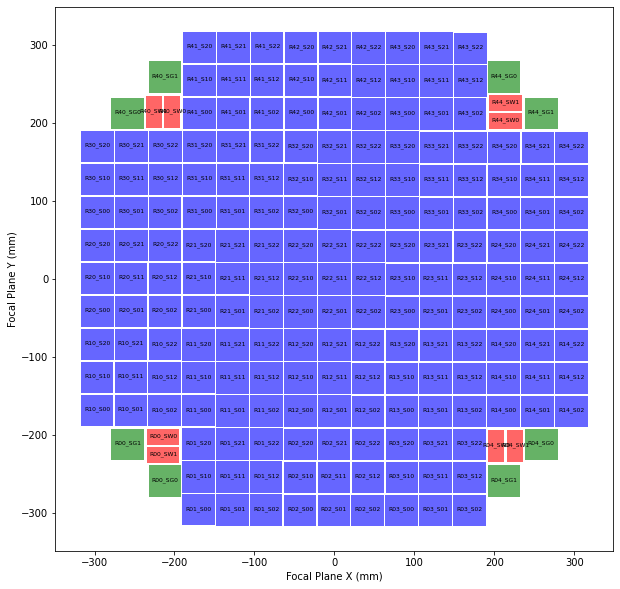

In [4]:
butler = dafPersist.Butler("./")
camera = butler.get('camera')
cgUtils.plotFocalPlane(camera)

The source code for `cgUtils.plotFocalPlane` found [here](https://github.com/lsst/afw/blob/01e196b6519ef91d51c61435065e16477972b897/python/lsst/afw/cameraGeom/utils.py#L87) gives us a very good place to start our investigation of the LSST camera geometry.

## Plot CCDs on Focal Plane

To get started, it's helpful to understand how to reproduce the figure above. The basic idea is to build an instance of the LSST camera object, and then loop through the detectors that it contains. For each detector, we plot the detector location and label the detector. We make a slight change to the code above by labeling with the CCD ID (a unique integer for each detector) rather than the `name` of the detector (which is built from the raft/sensor information)

Text(0, 0.5, 'Focal Plane Y (mm)')

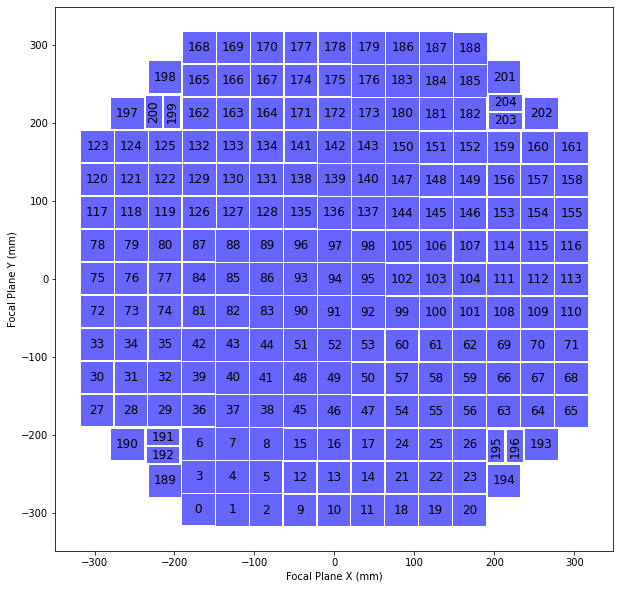

In [5]:
fig= plt.figure(figsize=(10,10))
ax = plt.gca()

xvals,yvals = [],[]
colors,patches = [],[]
for det in camera:
    corners = [(c.getX(), c.getY()) for c in det.getCorners(FOCAL_PLANE)]
    for corner in corners:
        xvals.append(corner[0])
        yvals.append(corner[1])
    colors.append('b')
    patches.append(Polygon(corners, True))
    center = det.getOrientation().getFpPosition()
    text = det.getId()
    rot = 90 if text in (195,196,199,200) else 0
    ax.text(center.getX(), center.getY(), text,
            ha='center', va='center', size=12, rotation=rot)

patchCollection = PatchCollection(patches, alpha=0.6, facecolor=colors)
ax.add_collection(patchCollection)

ax.set_xlim(min(xvals) - abs(0.1*min(xvals)),
            max(xvals) + abs(0.1*max(xvals)))
ax.set_ylim(min(yvals) - abs(0.1*min(yvals)),
            max(yvals) + abs(0.1*max(yvals)))
ax.set_xlabel('Focal Plane X (mm)')
ax.set_ylabel('Focal Plane Y (mm)')

## Plot Amps on a CCD

We'll start by grabbing the amps from a specific detector (the central detector R22,S11). We can then plot the extents of the amps in pixel coordinates.

Text(0, 0.5, 'CCD Y (pix)')

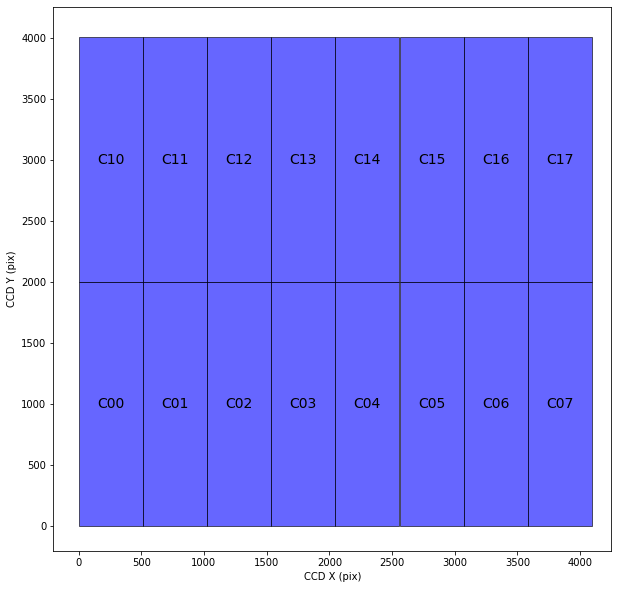

In [6]:
# Create the camera transformation
transform = LsstCameraTransforms(camera)
# Get the central detector
det = transform.getDetector('R22_S11')

# Get the amps for this detector
amps = det.getAmplifiers()

fig,ax = plt.subplots(1,figsize=(10,10))
patches,colors = [],[]
for amp in amps:
    corners = [(c.getX(), c.getY()) for c in amp.getBBox().getCorners()]
    patches.append(Polygon(corners, True))
    colors.append('b')
    center = amp.getBBox().getCenter()
    text = amp.getName()
    ax.text(center.getX(), center.getY(), text, color='k',
            ha='center', va='center', size=14)

# Add the patch collection
patchCollection = PatchCollection(patches, alpha=0.6, facecolor=colors,edgecolor='k')
ax.add_collection(patchCollection)

# Set some labels and extent
ax.set_xlim(-200,4250)
ax.set_ylim(-200,4250)
ax.set_xlabel('CCD X (pix)')
ax.set_ylabel('CCD Y (pix)')

Ok, so this is all well and good, but what if we want to plot the physical positions of the amps in focal plane coordinates? We should be able to do this with a transformation.

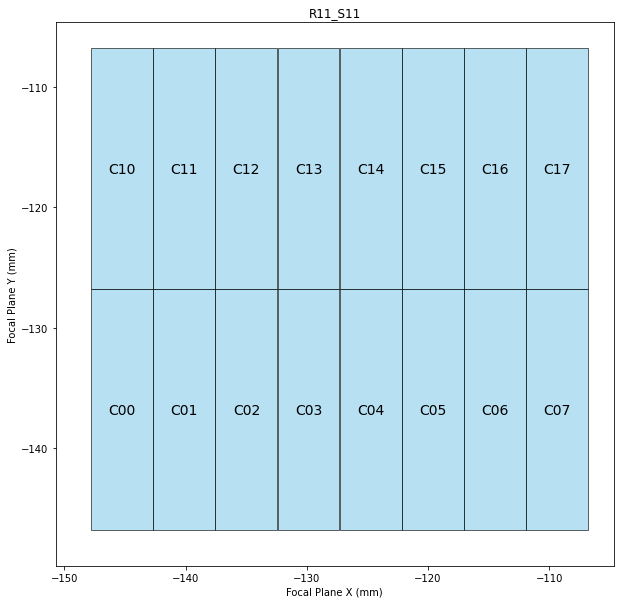

In [7]:
def plotFancyDetector(camera, detectorName='R22_S11', figsize=(10.,10.)):
    # Create the camera transformation
    transform = LsstCameraTransforms(camera)
    # Get the central detector
    det = transform.getDetector(detectorName)

    # Get the amps for this detector
    amps = det.getAmplifiers()

    fig,ax = plt.subplots(1,figsize=figsize)
    patches,colors = [],[]
    xvals,yvals = [],[]
    for amp in amps:
        points = [transform.ccdPixelToFocalMm(c.getX(), c.getY(), det.getName()) for c in amp.getBBox().getCorners()]
        corners = [(p.getX(),p.getY()) for p in points]
        for corner in corners:
            xvals.append(corner[0])
            yvals.append(corner[1])
        patches.append(Polygon(corners, True))
        colors.append('skyblue')
        # Center in pixels
        center_pix = amp.getBBox().getCenter()
        # center in mm
        center = transform.ccdPixelToFocalMm(center_pix.getX(),center_pix.getY(),det.getName())
        text = amp.getName()
        ax.text(center.getX(), center.getY(), text, color='k',
                ha='center', va='center', size=14)

    # Add the patch collection
    patchCollection = PatchCollection(patches, alpha=0.6, facecolor=colors,edgecolor='k')
    ax.add_collection(patchCollection)

    ax.set_xlim(min(xvals) - abs(0.02*min(xvals)),
                max(xvals) + abs(0.02*max(xvals)))
    ax.set_ylim(min(yvals) - abs(0.02*min(yvals)),
                max(yvals) + abs(0.02*max(yvals)))
    ax.set_xlabel('Focal Plane X (mm)')
    ax.set_ylabel('Focal Plane Y (mm)')
    ax.set_title(det.getName())

# Set some labels and extent
plotFancyDetector(camera,'R11_S11')

# Plot CCDs on a Raft

It looks like the LSST Camera object doesn't have the concept of a raft (just a list of detectors). If we want to assemble a raft, we can do so directly from the CCDs.

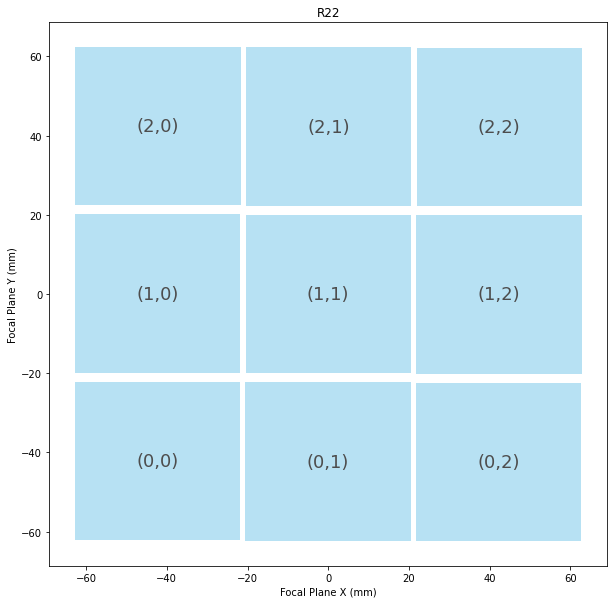

In [8]:
def plotFancyRaft(camera, raftName='R22', figsize=(10.,10.)):
    colorMap = {0: 'skyblue', 1: 'y', 2: 'g', 3: 'r'}
    transform = LsstCameraTransforms(camera)

    plt.figure(figsize=figsize)
    ax = plt.gca() 

    patches, colors = [],[]
    xvals, yvals = [],[]
    for det in camera:
        if not det.getName().startswith(raftName): continue
        corners = [(c.getX(), c.getY()) for c in det.getCorners(FOCAL_PLANE)]
        for corner in corners:
            xvals.append(corner[0])
            yvals.append(corner[1])
        colors.append(colorMap[int(det.getType())])
        patches.append(Polygon(corners, True))
        center = det.getOrientation().getFpPosition()
        name = det.getName()

        # Label central raft
        text = '(%s,%s)'%tuple(name.split('_')[1].strip('S'))
        ax.text(center.getX(), center.getY(), text, color='0.3',
                ha='center', va='center',size=18)      
             
    patchCollection = PatchCollection(patches, alpha=0.6, facecolor=colors)
    ax.add_collection(patchCollection)
    
    ax.set_xlim(min(xvals) - abs(0.1*min(xvals)),
                max(xvals) + abs(0.1*max(xvals)))
    ax.set_ylim(min(yvals) - abs(0.1*min(yvals)),
                max(yvals) + abs(0.1*max(yvals)))
    ax.set_xlabel('Focal Plane X (mm)')
    ax.set_ylabel('Focal Plane Y (mm)')
    ax.set_title(raftName)
    
plotFancyRaft(camera)

## Plot Focal Plane

Now we put together what we've learned to try to replicate the image [here](https://confluence.lsstcorp.org/display/LSWUG/Representation+of+a+Camera?preview=/4129064/10190878/LSST_FocalPlane.png#/). Note that the corner rafts (containing the focus and guiding CCDs) are not yet included in the `lsstCamera` model. Also, since the concept of a raft doesn't really exist, we don't plot outlines around the rafts (we could hack this if we wanted).

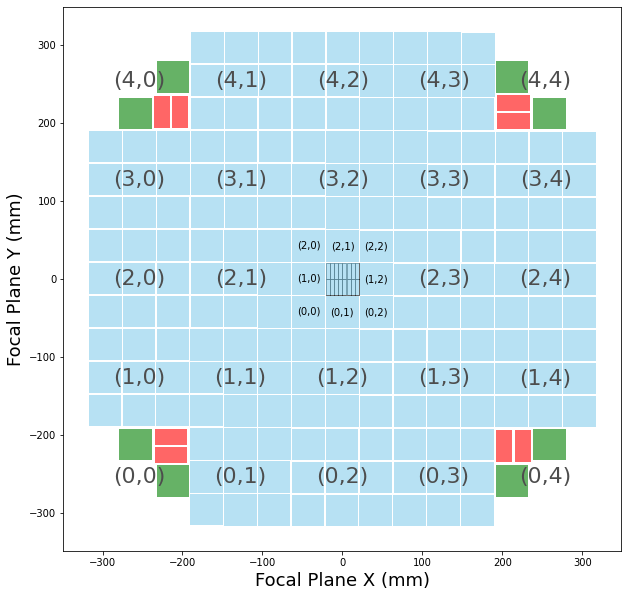

In [9]:
def plotFancyFocalPlane(camera, figsize=(10., 10.), showFig=True, savePath=None):
    """Make a plot of the focal plane along with a set points that sample
    the field of view.
 
    Parameters
    ----------
    camera : `lsst.afw.cameraGeom.Camera`
        A camera object
    figsize : `tuple` containing two `float`
        Matplotlib style tuple indicating the size of the figure in inches
    showFig : `bool`
        Display the figure on the screen?
    savePath : `str` or `None`
        If not `None`, save a copy of the figure to this name.
    """
    try:
        from matplotlib.patches import Polygon
        from matplotlib.collections import PatchCollection
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError(
            "Can't run plotFocalPlane: matplotlib has not been set up")

    colorMap = {0: 'skyblue', 1: 'y', 2: 'g', 3: 'r'}
    transform = LsstCameraTransforms(camera)

    plt.figure(figsize=figsize)
    ax = plt.gca()

    patches, colors = [],[]
    xvals, yvals = [],[]
    for det in camera:
        corners = [(c.getX(), c.getY()) for c in det.getCorners(FOCAL_PLANE)]
        for corner in corners:
            xvals.append(corner[0])
            yvals.append(corner[1])
        colors.append(colorMap[int(det.getType())])
        patches.append(Polygon(corners, True))
        center = det.getOrientation().getFpPosition()
        name = det.getName()

        # Label central raft
        if name.startswith('R22'):
            if not name.endswith('S11'):
                # Label CCDs for central raft
                text = '(%s,%s)'%tuple(name.split('_')[-1].strip('S'))
                ax.text(center.getX(), center.getY(), text,
                        ha='center', va='center', size=10)
            else:
                # Draw the amps for the central CCD
                amp_patches = []
                for amp in det.getAmplifiers():
                    points = [transform.ccdPixelToFocalMm(c.getX(), c.getY(), det.getName()) for c in amp.getBBox().getCorners()]
                    corners = [(p.getX(),p.getY()) for p in points]
                    amp_patches.append(Polygon(corners, True))
                # Add the amp patch collection
                patchCollection = PatchCollection(amp_patches, alpha=0.6, facecolor='none',edgecolor='k')
                ax.add_collection(patchCollection)
        elif name.endswith('S11'):
            text = '(%s,%s)'%tuple(name.split('_')[0].strip('R'))
            ax.text(center.getX(), center.getY(), text, color='0.3',
                    ha='center', va='center',size=22)
    for raft in ('R00', 'R40', 'R44', 'R04'):
        # These rafts don't have an S11 sensor, so need to figure out the raft center from the other rafts around them
        _, y, x = list(raft)
        column = camera[f'R1{x}_S11'].getOrientation().getFpPosition()  # Just needs to be in the column, could have used R2{x}
        row = camera[f'R{y}1_S11'].getOrientation().getFpPosition()  # Same for rows
        text = f'({y},{x})'
        ax.text(column.getX(), row.getY(), text, color='0.3',
                ha='center', va='center',size=22)
        
             
    patchCollection = PatchCollection(patches, alpha=0.6, facecolor=colors)
    ax.add_collection(patchCollection)
    
    ax.set_xlim(min(xvals) - abs(0.1*min(xvals)),
                max(xvals) + abs(0.1*max(xvals)))
    ax.set_ylim(min(yvals) - abs(0.1*min(yvals)),
                max(yvals) + abs(0.1*max(yvals)))
    
    ax.set_xlabel('Focal Plane X (mm)',fontsize=18)
    ax.set_ylabel('Focal Plane Y (mm)',fontsize=18)
    if savePath is not None:
        plt.savefig(savePath)
    if showFig:
        plt.show()

# Plot the focal plane        
plotFancyFocalPlane(camera)